# 

# Crop, reallocate and detect object - Yolov3
## Pipeline:
1. Load image via coco api
2. Get bounding box of object
3. Get center point of the bounding box
4. Define bounding square box
5. Create 4 images with object allocated to each corner
6. Make prediction

## 1. Load image via coco api

In [2]:
# Load libraries
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [3]:
# Define image directory
dataDir='.'
dataType='val2017'
annFile='{}/images/val2017_selected/annotations/instances_{}.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


In [4]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(', '.join(nms)))

# nms = set([cat['supercategory'] for cat in cats])
# print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush



In [5]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['airplane']);
imgIds = coco.getImgIds(imgIds = [1761])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
# keys of 'img' variable: 'flickr_url', 'id', 'date_captured', 'height', 'width', 'license', 'coco_url', 'file_name'

In [6]:
print(img)

{'date_captured': '2013-11-16 13:33:47', 'file_name': '000000001761.jpg', 'flickr_url': 'http://farm9.staticflickr.com/8519/8603794339_26f017bf31_z.jpg', 'width': 427, 'height': 640, 'id': 1761, 'license': 1, 'coco_url': 'http://images.cocodataset.org/val2017/000000001761.jpg'}


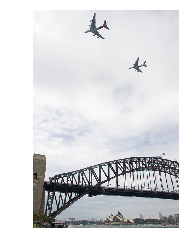

In [7]:
# load and display image
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [8]:
I.shape

(640, 427, 3)

## 2. Get bounding box of object


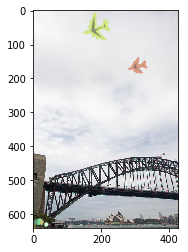

In [9]:
# load and display instance annotations
plt.imshow(I); plt.axis('on')
annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
anns = coco.loadAnns(annIds)
# keys of 'anns' variable: 'segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'
# bbox annotation: x, y, width, height

coco.showAnns(anns)

In [12]:
for object in anns:
    print(object['image_id'])
    print(object['bbox'])

1761
[282.23, 139.38, 51.22, 43.78]
1761
[150.17, 8.63, 74.09, 77.19]
1761
[11.61, 615.96, 4.84, 11.55]
1761
[4.28, 616.35, 7.22, 9.79]
1761
[15.58, 614.97, 6.23, 12.85]
1761
[36.24, 625.74, 4.8, 7.24]
1761
[21.28, 617.1, 7.33, 10.64]


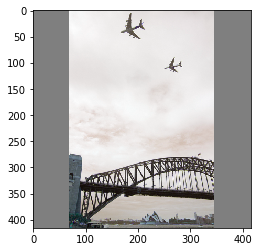

In [10]:
from utils.utils import preprocess_input_PIL
new_image = preprocess_input_PIL(I, 416, 416)
plt.imshow(new_image)

## 3. Get center point of the bounding box

In [11]:
def bbox_center(bbox_info):
    """
    Returns center point and max of (width, height)
    """
    x, y, w, h = bbox_info
    x_center = x + w/2
    y_center = y + h/2
    return (x_center, y_center), max([w, h])

obj_center, obj_sz = bbox_center(anns[0]['bbox'])
print('object center point: {} \nobject size: {}'.format(obj_center, obj_sz))

object center point: (307.84000000000003, 161.26999999999998) 
object size: 51.22


## 4. Define bounding square box

In [12]:
import torchvision.transforms.functional as TF
import PIL

In [13]:
def square_cell(center_point, edge_value):
    padding_size = 0
    x_center, y_center = center_point
    x = x_center - edge_value/2 - padding_size
    y = y_center - edge_value/2 - padding_size
    w = edge_value + 2*padding_size
    h = edge_value + 2*padding_size
    return x, y, w, h

image_path = '/Users/haiho/Unimelb/COMP90055-ResearchProject/Software/coco/val2017/'+img['file_name']
I_pil = PIL.Image.open(image_path)
crop_x, crop_y, crop_w, crop_h = square_cell(obj_center, obj_sz)
# crop_x, crop_y, crop_w, crop_h = anns[0]['bbox']
crop_img = TF.crop(I_pil, crop_y, crop_x, crop_h, crop_w)

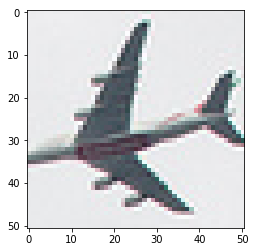

In [14]:
plt.imshow(np.asarray(crop_img))
plt.show()

## 5. Create 4 images with object allocated to each corner

In [15]:
def create_test_images(image, cell_x, cell_y, cell_w, cell_h):
    new_w, new_h = cell_w*2, cell_h*2
    corners = [[0,0], [0,1], [1,0], [1,1]]
    test_images = list()
    for corner in corners:
        compensate_x, compensate_y = corner
        new_x = cell_x - compensate_x * cell_w
        new_y = cell_y - compensate_y * cell_h
        test_image = TF.crop(image, new_y, new_x, new_h, new_w)
        test_images.append(test_image)
    return test_images

In [16]:
def create_test_images2(image, cell_x, cell_y, cell_w, cell_h):
    im_w, im_h = image.size
    corners = [[0,0], [0,1], [1,0], [1,1]]
    test_images = list()
    for corner in corners:
        compensate_x, compensate_y = corner
        new_x = compensate_x * cell_x
        new_y = compensate_y * cell_y
        new_h = compensate_y * (im_h - cell_y) + (1 - compensate_y) * (cell_y + cell_h)
        new_w = compensate_x * (im_w - cell_x) + (1 - compensate_x) * (cell_x + cell_w)
        test_image = TF.crop(image, new_y, new_x, new_h, new_w)
        test_images.append(test_image)
    return test_images

In [17]:
new_images = create_test_images2(I_pil, crop_x, crop_y, crop_w, crop_h)
im1, im2, im3, im4 = new_images


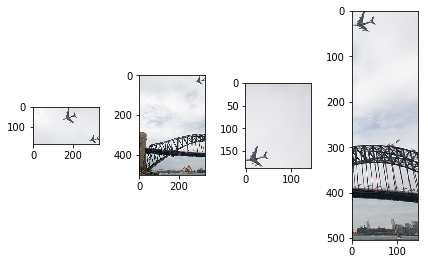

In [28]:
fig, axs = plt.subplots(1, 4)
axs[0].imshow(np.asarray(im1))
axs[1].imshow(np.asarray(im2))
axs[2].imshow(np.asarray(im3))
axs[3].imshow(np.asarray(im4))
fig.tight_layout()
plt.show()

In [19]:
im4.save("im1.jpg") 

## 6. Make prediction

In [1]:
from utils.bbox import *
from utils.colors import *
from utils.image import *
from utils.utils import *
from utils.modelling import *
from make_show_result import *
from keras.models import load_model
from tensorflow.python.util import deprecation
import matplotlib.pyplot as plt
import ipywidgets as widgets
import torch
import torchvision
import torchvision.transforms.functional as TF
import PIL
deprecation._PRINT_DEPRECATION_WARNINGS = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [33]:
# load yolov3 model
model = load_model('yolov3_model.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
          "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
          "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
          "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
          "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
          "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
          "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
          "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
          "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]


[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


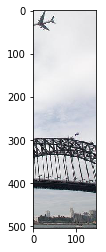

In [34]:
# define our new photo
photo_filename = 'im1.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])

boxes = list()
for i in range(len(yhat)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.6)
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

show_boxes(photo_filename, v_boxes, v_labels, v_scores)
for box in v_boxes:
    y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
    print(y1, x1, y2, x2)

In [35]:
print(image_w, image_h)

145 504
